<a href="https://colab.research.google.com/github/kgeneral/Hands-On-MachineLearning-2nd/blob/master/13_loading_and_preprocessing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF 기반의 데이터 적재 / 전처리

In [1]:
# kakao arena 멜론 추천 대회 데이터(genre_gn_all.json) : 구글 드라이브 링크는 비활성화 예정
!wget -O genre_gn_all.json "https://drive.google.com/u/0/uc?id=13f7anLzjW5R4yk6saiQdoqNje8hWrlZa&export=download" 
!head ./genre_gn_all.json

--2020-06-30 07:52:58--  https://drive.google.com/u/0/uc?id=13f7anLzjW5R4yk6saiQdoqNje8hWrlZa&export=download
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.113, 74.125.142.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uo0jvoin1ua842ateskv1og73msd4d1f/1593503550000/14905503537404824244/*/13f7anLzjW5R4yk6saiQdoqNje8hWrlZa?e=download [following]
--2020-06-30 07:52:59--  https://doc-0g-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uo0jvoin1ua842ateskv1og73msd4d1f/1593503550000/14905503537404824244/*/13f7anLzjW5R4yk6saiQdoqNje8hWrlZa?e=download
Resolving doc-0g-ak-docs.googleusercontent.com (doc-0g-ak-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0g-ak-docs.googleusercontent.com (do

In [2]:
# 다음 cell의 import 수행 후 pd.read_json 진행시 pd 내부 모듈 import 오류 발생. 의존성 라이브러리 끼리 충돌이 발생 하는 듯
import pandas as pd
genre_gn_all = pd.read_json('genre_gn_all.json', typ = 'series')
# 장르코드 : gnr_code, 장르명 : gnr_name
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})
genre_gn_all[:20]

gnr_code   gnr_name
0    GN0100        발라드
1    GN0101     세부장르전체
2    GN0102        '80
3    GN0103        '90
4    GN0104        '00
5    GN0105       '10-
6    GN0200         댄스
7    GN0201     세부장르전체
8    GN0202        '80
9    GN0203        '90
10   GN0204        '00
11   GN0205       '10-
12   GN0300       랩/힙합
13   GN0301     세부장르전체
14   GN0302      랩 스타일
15   GN0303     보컬 스타일
16   GN0304  언더그라운드 힙합
17   GN0305        시대별
18   GN0400   R&B/Soul
19   GN0401     세부장르전체

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

You can safely ignore the package incompatibility errors.


In [4]:
#!bash

# Overview

## Dataset API
- `tf.data.Dataset` : https://www.tensorflow.org/api_docs/python/tf/data/Dataset
- 데이터셋의 반복, 배치묶음, 셔플, 프리패치 등의 내부 인터페이스화로, 학습 단계에서 해당 구현부에 대한 의존 관계를 분리

## TFRecord
- TF 에서 효율적으로 사용될 수 잇는 binary format 의 자체 데이터셋 규격
- TF 내부적으로 Protocol buffer 로 정의된 `tf.train.Example` 등 저장 구현 편의성 클래스 제공

### Protocol buffer
- https://developers.google.com/protocol-buffers
- Google 에서 개발된, structured data 를 위한 프로토콜
- gRPC 통신 규격 등으로 널리 사용됨

## 학습용 input data(feature) 의 전처리
- https://www.tensorflow.org/api_docs/python/tf/feature_column
- `tf.feature_column` 에 정의된 다양한 컬럼형태 변환 기능을 활용가능

### 제공되는 컬럼변환
 - `numeric_column()`
 - `bucketized_column()`
 - `categorical_column_with_vocabulary_list()`
 - `categorical_column_with_hash_bucket()`
 - `crossed_column()`
 - `indicator_column()`
 - `embedding_column()`

### 사용 형태
- 상기의 컬럼 변환 정의를 선언한 뒤, 필요한 컬럼 정의들을 목록화 하고 실제 전처리 진행
- 자세한 내용은 하기 코드 구현 참고

## TF Transform
- 아주 큰 데이터를 다룰 때에는, Spark 등의 대규모 데이터 처리 프레임워크를 사용하여 전처리 하는 방법도 있지만, 이러한 전처리 과정이 이에 연동되는 어플리케이션 개발에 의존성이 걸리게 된다.
- TFT 에서 선언된 함수는 Apache Beam 등과 전처리 연동이 가능하고, 전처리 로직에 텐서플로우 기능 사용이 가능 하다는 장점을 가진다.

## TFDS
- https://www.tensorflow.org/datasets/api_docs/python/tfds
- 텐서플로우 표준 데이터 셋
- 별도 선처리 없이 `tf.data.Dataset` 로 바로 로드하여 사용이 가능
- 이미지, 오디오, 텍스트 등 다양한 데이터 셋 제공

## TF Hub
- https://www.tensorflow.org/hub?hl=ko
- 기 학습된 모델들을 쉽게 keras layer 등으로 가져다 쓸 수 있는 장점이 있다.
- 이미지/텍스트 분류기, Object detection 등 실무적으로 성능이 검증된 모델들이 존재

## Datasets

In [5]:
# X = tf.range(10)
# dataset = tf.data.Dataset.from_tensor_slices(X)

# dataset = tf.data.Dataset.range(10)

# pandas dataframe 을 바로 사용 가능
dataset = tf.data.Dataset.from_tensor_slices(genre_gn_all)
dataset

<TensorSliceDataset shapes: (2,), types: tf.string>

In [6]:
# TF 자료 구조에서 한글이 byte 로 출력되는 문제로, 디버그용 프린트 구현
def printGenre(item):
  tf.print(item[0], item[1].numpy().decode("utf-8"))

In [7]:
for item in dataset.take(10):
    printGenre(item)

"GN0100" 발라드
"GN0101" 세부장르전체
"GN0102" '80
"GN0103" '90
"GN0104" '00
"GN0105" '10-
"GN0200" 댄스
"GN0201" 세부장르전체
"GN0202" '80
"GN0203" '90


연쇄 변환
- `repeat(n)` : 원본을 n 번 반복
- `batch(m)` : 개별 item 기준으로 m 개씩을 batch array 로 꺼냄

![](https://pic1.zhimg.com/80/v2-3b242922714b46837ac7a5ca55c63638_1440w.jpg)

In [8]:
dataset_batch = dataset.repeat(3).batch(7)
for batch_items in dataset_batch.take(1):
    for item in batch_items: # batch 1 묶음 분 출력
      printGenre(item)

"GN0100" 발라드
"GN0101" 세부장르전체
"GN0102" '80
"GN0103" '90
"GN0104" '00
"GN0105" '10-
"GN0200" 댄스


In [9]:
# 모든 카테고리는 GN 으로 시작하므로 prefix 를 일괄 삭제하기를 원함
# https://www.tensorflow.org/api_docs/python/tf/stack
# https://www.tensorflow.org/api_docs/python/tf/strings/regex_replace

dataset_mapped = dataset.map(lambda x: tf.stack([tf.strings.regex_replace(x[0],"GN",""),x[1]]))

In [10]:
for item in dataset_mapped.take(10):
    printGenre(item)

"0100" 발라드
"0101" 세부장르전체
"0102" '80
"0103" '90
"0104" '00
"0105" '10-
"0200" 댄스
"0201" 세부장르전체
"0202" '80
"0203" '90


In [11]:
#dataset = dataset.apply(tf.data.experimental.unbatch()) # Now deprecated
#dataset = dataset_batch.unbatch()

In [12]:
# 대분류 장르코드
# 대분류 장르코드는 장르코드(gnr_code)에서 숫자 네 자리 중 뒷자리 두 자리가 00인 코드로 분류할 수 있습니다.

dataset_filter = dataset_mapped.filter(lambda x: tf.strings.substr(x[0], 2, 2) == "00")  

for item in dataset_filter.take(10):
    printGenre(item)

"0100" 발라드
"0200" 댄스
"0300" 랩/힙합
"0400" R&B/Soul
"0500" 인디음악
"0600" 록/메탈
"0700" 성인가요
"0800" 포크/블루스
"0900" POP
"1000" 록/메탈


In [13]:
# 데이터 셔플링
# 메모리에 올리기 버거울 정도로 파일 사이즈가 큰 경우, 원본 파일 자체를 shuffle 하는 방법도 있음
tf.random.set_seed(42)

dataset_shuffle = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for items in dataset_shuffle.take(1):
    for item in batch_items: # batch 1 묶음 분 출력
      printGenre(item)


"GN0100" 발라드
"GN0101" 세부장르전체
"GN0102" '80
"GN0103" '90
"GN0104" '00
"GN0105" '10-
"GN0200" 댄스


In [14]:
# shuffle 후 repeat 을 사용시 repeat 시마다 순서가 달라짐
for item in dataset.shuffle(buffer_size=3).repeat(3).batch(4).take(1):
    for item in batch_items: # batch 1 묶음 분 출력
      printGenre(item)

print("\n\n")

for item in dataset.shuffle(buffer_size=3).repeat(3).batch(4).take(1):
    for item in batch_items: # batch 1 묶음 분 출력
      printGenre(item)

"GN0100" 발라드
"GN0101" 세부장르전체
"GN0102" '80
"GN0103" '90
"GN0104" '00
"GN0105" '10-
"GN0200" 댄스



"GN0100" 발라드
"GN0101" 세부장르전체
"GN0102" '80
"GN0103" '90
"GN0104" '00
"GN0105" '10-
"GN0200" 댄스


## California dataset - 여러 CSV 파일에서 데이터 로드

- sklearn 에서 제공되는 캘리포니아 집값 데이터를 tf 예제 에서 활용하기 위한 코드
- 데이터를 다운로드 / 전처리 하여 20 개 csv 파일로 저장

In [15]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [16]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [17]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [18]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

MedInc  HouseAge  AveRooms  ...  Latitude  Longitude  MedianHouseValue
0  3.5214      15.0  3.049945  ...     37.63    -122.43             1.442
1  5.3275       5.0  6.490060  ...     33.69    -117.39             1.687
2  3.1000      29.0  7.542373  ...     38.44    -122.98             1.621
3  7.1736      12.0  6.289003  ...     33.55    -117.70             2.621
4  2.0549      13.0  5.312457  ...     33.93    -116.93             0.956

[5 rows x 9 columns]

In [19]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [20]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

## TF 에서 여러 파일로부터 데이터 읽어들이기
- 메모리보다 데이터의 사이즈가 대단히 큰 경우를 가정

In [21]:
# 결과의 파일 경로는 기본적으로 shuffle 됨
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [22]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Ten

In [23]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#interleave
# 여러 경로의 파일에서 데이터를 하나식 읽어들임. 병렬로 실행되지는 않음
# list_files 호출 시점에 파일목록이 shuffle 되어 잇기 때문에, 데이터가 shuffle 되는 효과가 남
# 파일 사이즈가 균일한 것이 좋음

n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # header line 무시
    cycle_length=n_readers)
dataset

<InterleaveDataset shapes: (), types: tf.string>

In [24]:
for line in dataset.take(5):
    print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'


In [25]:
# 각 column 의 default type 도 같이 정해짐 (4th column 은 string)
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

특정 column 이 비어 잇는 경우 기정의된 default 값이 됨

In [26]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

 `tf.constant([])` 로 정의되어 잇는 컬럼은 required 로 처리되어, 비어 잇으면 오류가 발생

In [27]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


`record_defaults` 에 정의된 dimension 과 일치하지 않으면 오류 발생

In [28]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [29]:
n_inputs = 8 # X_train.shape[-1]

# https://www.tensorflow.org/guide/function?hl=ko#tffunction_%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0
# tf.function을 함수에 붙여줄 경우, 여전히 다른 일반 함수들처럼 사용할 수 있습니다. 
# 하지만 그래프 내에서 컴파일 되었을 때는 더 빠르게 실행하고, GPU나 TPU를 사용해서 작동하고, 세이브드모델(SavedModel)로 내보내는 것이 가능해집니다.
@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1]) # tf.tensor 를 만드는 부분
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y # normalized X and y

In [30]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

데이터 적재 + 전처리

![](https://pic1.zhimg.com/80/v2-bbd864e5a99678090a5bb8567032c9c0_1440w.jpg)

In [31]:
# 파일 로드 및 전처리를 통합한 함수
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1) # 1 개의 batch 를 prefetch

프리페치
- GPU 등의 device에서 학습 중일 때 다음 데이터를 CPU 가 미리 꺼내 놓는 테크닉
- multicore 환경이라면 더욱 이점으로 활용할 수 잇다.

![](https://pic4.zhimg.com/80/v2-3be19d36338ad366370616e51ee0ecbb_1440w.jpg)

- https://www.tensorflow.org/api_docs/python/tf/data/experimental/prefetch_to_device
 - 특정 device 로의 명시적 prefetch 를 진행

In [32]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



In [33]:
train_set = csv_reader_dataset(train_filepaths, repeat=None) # repeat=None 즉 무한하게 반복됨
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [34]:
keras.backend.clear_session() # https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [35]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [37]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 1.4679 - val_loss: 21.5124
Epoch 2/10
362/362 [==============================] - 1s 3ms/step - loss: 0.8735 - val_loss: 0.6648
Epoch 3/10
362/362 [==============================] - 1s 3ms/step - loss: 0.6317 - val_loss: 0.6196
Epoch 4/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5933 - val_loss: 0.5669
Epoch 5/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5629 - val_loss: 0.5402
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5693 - val_loss: 0.5209
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5231 - val_loss: 0.6130
Epoch 8/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5074 - val_loss: 0.4818
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4963 - val_loss: 0.4904
Epoch 10/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5023 - val_loss: 0.458

In [38]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.4788


0.4787752628326416

In [39]:
new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[2.3576407],
       [2.255291 ],
       [1.4437605],
       ...,
       [0.5654393],
       [3.9442453],
       [1.0232248]], dtype=float32)

In [40]:
# 학습 로직을 풀어서 구현
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [41]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [43]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [44]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


`tf.data.Dataset` 내장 메서드

In [45]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()      

## `TFRecord` 포맷
- TF 전용 binary format 으로 입출력 속도가 빠름
- record 길이, 실제 데이터, 각각 검증용 checksum 으로 이루어짐
- 네트워크 전송 등을 용이하게 하기 위해 GZIP 압축 지원

In [46]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [47]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [48]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [49]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [50]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### Protocol Buffers

- 구글에서 2001년 개발된 이진 포맷
- TFRecord, 구글의 gRPC 프로토콜에 널리 사용


In [51]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


아래와 같이 컴파일

- `tf.io.decode_proto()` 사용을 위해서는 `--descriptor_set_out`, `--include_imports` 옵션 부여가 필요

In [52]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [53]:
!ls person*

person.desc  person_pb2.py  person.proto


컴파일 후 파이썬에서 사용 가능 : 마치 OOP 의 도메인 객체와 같은 형태
- field getter/setter, (de)serialize, comparer 등의 기능 제공

In [54]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [55]:
person.name  # read a field

'Al'

In [56]:
person.name = "Alice"  # modify a field

In [57]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [58]:
person.email.append("c@d.com")  # add an email address

In [59]:
s = person.SerializeToString()  # serialize to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [60]:
# (네트워크 통신 등으로) byte string 을 받아서 parsing 해야 하거나 할 때

person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)

27

In [61]:
person == person2  # now they are equal

True

`tf.io.decode_proto()` 를 통해, 기정의된 proto 를 code description 을 통해 parse 할 수 있다.

In [62]:
# https://www.tensorflow.org/api_docs/python/tf/io/decode_proto
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

### TensorFlow Protobufs

기 정의되어 잇는 tf.train.Example protobuf 의 구조

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

`from tensorflow.train import X` (tf.train 내의 임의의 모듈) 에 버그가 존재하여, `X = tf.train.X` 로 우회하면 사용 가능
 
- https://github.com/tensorflow/tensorflow/issues/33289 
- TF version 2.2.rc3 에서 해결 되었다고 함

In [63]:
#from tensorflow.train import BytesList, FloatList, Int64List
#from tensorflow.train import Feature, Features, Example
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [64]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [65]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f7c6f194e48>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [66]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f7c6f194e48>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [67]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [68]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [69]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

### TFRecords 로 이미지 저장 / 로드
- BytesList 자료 구조를 활용

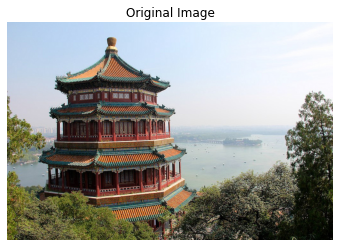

In [70]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [71]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
# then save to TFRecord

In [72]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

In [73]:
# BMP, GIF, JPEG, PNG 등 지원
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])

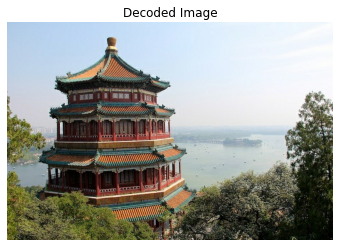

In [74]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

### Tensor 를 TFRecords 로 저장

Tensor 의 (de)serialize 처리

- `tf.io.serialize_tensor()`
- `tf.io.parse_tensor()`:

In [75]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
# https://www.tensorflow.org/api_docs/python/tf/io/serialize_tensor
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [76]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [77]:
"""
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7feadc328550>,
...
}
"""
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [78]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [79]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [80]:
parsed_examples

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f7c6f2339e8>,
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

##  Sequential Data 형식 : `SequenceExample`
- 1 : n 관계의 데이터를 표현하는 규격
  - 예) 글 작성자 : 댓글

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

In [81]:
#from tensorflow.train import FeatureList, FeatureLists, SequenceExample
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [82]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [83]:
serialized_sequence_example = sequence_example.SerializeToString()

In [84]:
# context : 작성자, sequence : 본문 / 댓글
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [85]:
parsed_context

{'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>,
 'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f7c77a2bbe0>}

In [86]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [87]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f7c77a2bd68>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f7c77a2b710>}

In [88]:
# https://www.tensorflow.org/api_docs/python/tf/RaggedTensor
# ragged dimensions 즉 불규칙한 크기의 dimensions 들의 묶음
# 단어 array 의 array 형태의 묶임이 필요하여 RaggedTensor 사용
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# 입력 데이터 전처리

- https://www.tensorflow.org/tutorials/structured_data/feature_columns?hl=ko


In [89]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [90]:
fetch_housing_data()

In [91]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [92]:
housing = load_housing_data()
housing.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

In [93]:
# 판다스 데이터프레임으로부터 tf.data 데이터셋을 만들기 위한 함수
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('median_house_value')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [94]:
batch_size=32

housing_ds = df_to_dataset(housing, batch_size=batch_size)
example_batch = next(iter(housing_ds))[0] # 1st batch data 를 꺼냄
tf.print(example_batch)

{'households': [163 302 316 ... 288 250 341],
 'housing_median_age': [36 37 4 ... 18 20 34],
 'latitude': [33.92 32.69 38.11 ... 33.61 33.49 38],
 'longitude': [-118.25 -117.1 -121.26 ... -117.92 -115.84 -122.3],
 'median_income': [4.1042 2.2102 4.2448 ... 5.3369 2.0347 4.4394],
 'ocean_proximity': ["<1H OCEAN" "NEAR OCEAN" "INLAND" ... "<1H OCEAN" "INLAND" "NEAR BAY"],
 'population': [502 1369 933 ... 425 637 956],
 'total_bedrooms': [164 340 366 ... 425 379 317],
 'total_rooms': [949 1269 2058 ... 1538 1660 1712]}


Normalize

In [95]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [96]:
# 특성 열을 만들고 배치 데이터를 변환하는 함수
def demo(feature_column):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [97]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_mean = scaler.mean_
# X_std = scaler.scale_

age_mean, age_std = np.mean(housing["housing_median_age"]), np.std(housing["housing_median_age"])
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

In [98]:
demo(housing_median_age)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 0.5848523 ]
 [ 0.66431034]
 [-1.9578062 ]
 [-0.76593506]
 [-0.76593506]
 [-0.76593506]
 [-0.20972851]
 [ 0.4259361 ]
 [-0.05081235]
 [ 0.90268457]
 [-1.0043093 ]
 [ 0.66431034]
 [-1.7988901 ]
 [ 0.90268457]
 [ 0.34647804]
 [ 0.9821427 ]
 [-0.2891866 ]
 [ 1.8561815 ]
 [ 0.74376845]
 [-1.0043093 ]
 [ 0.34647804]
 [ 0.4259361 ]
 [ 1.8561815 ]
 [ 1.6972654 ]
 [-1.0043093 ]
 [-1.4015996 ]
 [ 0.1081038 ]
 [ 1.299975  ]
 [ 0.1081038 ]
 [-0.8453931 ]
 [-0.686477  ]
 [ 0.4259361 ]]


Bucketize
- 연속형 값을 범주형 으로 변환

In [99]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

In [100]:
demo(median_income)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 4.1042]
 [ 2.2102]
 [ 4.2448]
 [ 3.125 ]
 [ 3.1591]
 [ 5.7409]
 [ 4.9107]
 [ 3.5938]
 [ 4.8571]
 [ 5.4689]
 [ 2.8229]
 [ 2.1875]
 [ 1.4639]
 [ 5.9845]
 [ 3.0625]
 [ 3.4583]
 [ 1.4617]
 [ 4.218 ]
 [ 1.8661]
 [12.0088]
 [ 3.5978]
 [ 2.0538]
 [ 3.75  ]
 [ 2.2097]
 [ 4.6563]
 [ 4.5568]
 [ 5.8521]
 [ 2.6051]
 [ 3.099 ]
 [ 5.3369]
 [ 2.0347]
 [ 4.4394]]


In [101]:
demo(bucketized_income)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0.

One hot vector
- 범주형 값을 vector 로 매핑하는 기법
- category 의 수를 dimension 으로 하여, 한개 column 을 1 나머지값을 0 으로 표현

In [102]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)

In [103]:
# ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
example_batch["ocean_proximity"]

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'<1H OCEAN', b'NEAR OCEAN', b'INLAND', b'INLAND', b'INLAND',
       b'NEAR OCEAN', b'<1H OCEAN', b'<1H OCEAN', b'INLAND', b'INLAND',
       b'<1H OCEAN', b'<1H OCEAN', b'<1H OCEAN', b'<1H OCEAN',
       b'<1H OCEAN', b'<1H OCEAN', b'<1H OCEAN', b'NEAR BAY',
       b'<1H OCEAN', b'<1H OCEAN', b'INLAND', b'<1H OCEAN', b'NEAR BAY',
       b'<1H OCEAN', b'INLAND', b'INLAND', b'<1H OCEAN', b'<1H OCEAN',
       b'INLAND', b'<1H OCEAN', b'INLAND', b'NEAR BAY'], dtype=object)>

In [104]:
# Just an example, it's not used later on
# city_hash = tf.feature_column.categorical_column_with_hash_bucket(
#     "city", hash_bucket_size=1000)
# city_hash
ocean_hash_bucket = tf.feature_column.categorical_column_with_hash_bucket(
    "ocean_proximity", hash_bucket_size=5)
demo(tf.feature_column.indicator_column(ocean_hash_bucket))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0.

In [105]:
# https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column
# 주어진 categorical column 에 대한 multi-hot representation 을 제공

ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)
demo(ocean_proximity_one_hot)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0.

In [106]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]) # age was scaled
# 두 개 이상의 특성에 대한 교차 특성
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

demo(tf.feature_column.indicator_column(age_and_ocean_proximity))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [107]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

demo(tf.feature_column.indicator_column(location))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text embedding
- 범주형 등의 문자형 데이터를 vector 로 매핑하는 기법
- 학습을 통해 vector 값을 더욱 유의미 하게 만들수 있다.
  - 뉴스 기사를 통한 Word embedding 등



In [108]:
# text vectorize 의 raw implementation 예시

# text input 을 알파벳 아닌 문자는 space 로 치환, 일정한 길이가 되도록 padding 처리
from collections import Counter

def preprocess_sentence(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

# word 단위로 count 후, most common 순서로 max_size 개의 unique word 를 가져옴
def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess_sentence(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets # Number of buckets to use for out-of-vocabulary keys

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64) # for incremental id (1, 2, 3, ...)
        # https://www.tensorflow.org/api_docs/python/tf/lookup/KeyValueTensorInitializer
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids) # keys, values
        # https://www.tensorflow.org/api_docs/python/tf/lookup/StaticVocabularyTable
        # 실질적인 매핑 테이블 생성
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess_sentence(inputs)
        return self.table.lookup(preprocessed_inputs)

In [109]:
X_example = tf.constant(
    ["It's a great, great movie! I loved it.", 
     "It was terrible, run away!!!"]
    )

text_vectorization = TextVectorization()

text_vectorization.adapt(X_example) # adapt
text_vectorization(X_example) # call

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

In [110]:
input_array = np.random.randint(1000, size=(10, 10)) # 1~1000
input_array

array([[102, 435, 860, 270, 106,  71, 700,  20, 614, 121],
       [466, 214, 330, 458,  87, 372,  99, 871, 663, 130],
       [661, 308, 769, 343, 491, 413, 805, 385, 191, 955],
       [276, 160, 459, 313,  21, 252, 747, 856, 560, 474],
       [ 58, 510, 681, 475, 699, 975, 782, 189, 957, 686],
       [957, 562, 875, 566, 243, 831, 504, 130, 484, 818],
       [646,  20, 840, 166, 273, 387, 600, 315,  13, 241],
       [776, 345, 564, 897, 339,  91, 366, 955, 454, 427],
       [508, 775, 942,  34, 205,  80, 931, 561, 871, 387],
       [  1, 389, 565, 105, 771, 821, 476, 702, 401, 729]])

In [111]:
# https://www.tensorflow.org/tutorials/text/word_embeddings
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
embedding_layer = tf.keras.layers.Embedding(1000, 2) # 1~1000
result = embedding_layer(input_array) # layer 로 사용 시 vectorized 된 값이어야 함(text input 직접입력 등 X)
result.numpy()

array([[[-2.60306355e-02,  8.35730880e-03],
        [ 2.43067183e-02,  1.65507533e-02],
        [-1.12452507e-02, -4.33656946e-02],
        [ 3.15601565e-02,  4.55017351e-02],
        [-1.45568624e-02, -3.44450958e-02],
        [-1.16505995e-02,  4.61771004e-02],
        [-2.46401671e-02, -1.55456886e-02],
        [-9.88269970e-03,  1.66232474e-02],
        [ 2.40157731e-02, -1.11000650e-02],
        [-5.96866012e-05, -1.00355260e-02]],

       [[-3.45583782e-02,  2.70949490e-02],
        [ 3.56859677e-02, -3.57064493e-02],
        [-8.58211517e-03,  3.39626148e-03],
        [ 7.58720562e-03, -4.53711413e-02],
        [ 4.60234620e-02, -2.30839606e-02],
        [-7.45673105e-03,  1.46443360e-02],
        [-2.09954269e-02, -4.42221165e-02],
        [ 2.63983048e-02,  3.09937857e-02],
        [ 4.41609882e-02,  4.18404453e-02],
        [-4.92367409e-02,  1.52570941e-02]],

       [[ 2.64430381e-02,  1.85478963e-02],
        [ 2.04598941e-02,  3.57128866e-02],
        [-1.86036117e-02, -7

In [112]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)

demo(ocean_proximity_embed)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[-0.39534152 -0.3781051 ]
 [-0.14504611  0.7563394 ]
 [-1.1119912   0.56957847]
 [-1.1119912   0.56957847]
 [-1.1119912   0.56957847]
 [-0.14504611  0.7563394 ]
 [-0.39534152 -0.3781051 ]
 [-0.39534152 -0.3781051 ]
 [-1.1119912   0.56957847]
 [-1.1119912   0.56957847]
 [-0.39534152 -0.3781051 ]
 [-0.39534152 -0.3781051 ]
 [-0.39534152 -0.3781051 ]
 [-0.39534152 -0.3781051 ]
 [-0.39534152 -0.3781051 ]
 [-0.39534152 -0.3781051 ]
 [-0.39534152 -0.3781051 ]
 [ 0.20670882  0.31640428]
 [-0.39534152 -0.37810

### `tf.feature_column` 로 정의된 컬럼을 데이터 parsing 단계에 사용

In [113]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

In [114]:
# 정의된 tf.feature_column 들을 나열하여 필요한 feature 들을 선택
columns = [
           housing_median_age, 
           median_house_value
           ]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [115]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=[x])),
            "median_house_value": Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())

In [116]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [117]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

for item in dataset.take(1):
  tf.print(item)

({'housing_median_age': [[44]
 [26]
 [13]
 ...
 [4]
 [24]
 [14]]}, [[4.592]
 [0.821]
 [0.916]
 ...
 [2.017]
 [3.338]
 [1.885]])


In [118]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target), 
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
362/362 [==============================] - 1s 2ms/step - loss: 3.8278 - accuracy: 0.0016
Epoch 2/5
362/362 [==============================] - 1s 2ms/step - loss: 1.8508 - accuracy: 0.0024
Epoch 3/5
362/362 [==============================] - 1s 2ms/step - loss: 1.4744 - accuracy: 0.0032
Epoch 4/5
362/362 [==============================] - 1s 2ms/step - loss: 1.3446 - accuracy: 0.0028
Epoch 5/5
362/362 [==============================] - 1s 2ms/step - loss: 1.3325 - accuracy: 0.0032


In [119]:
# 1 embedded, 1 bucketized column
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.14504611,  0.7563394 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -1.1119912 ,  0.56957847],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.1119912 ,  0.56957847]], dtype=float32)>

# Keras 전처리 Layer

In [120]:
normalization = tf.keras.layers.experimental.preprocessing.Normalization()
#discretization = tf.keras.layers.experimental.preprocessing.Discretization([0., 1., 2.]) # nightly only
preprocessing_layer = tf.keras.layers.experimental.preprocessing.PreprocessingLayer([normalization])
preprocessing_layer.adapt(dataset) # 필요한 전처리 layer 에 삽입

# model = keras.models.Sequential([
#     tf.keras.layers.Dense(30, activation="relu", input_shape=(...)),
#     preprocessing_layer,
#     tf.keras.layers.Dense(10, activation='softmax'),
# ])

# Tensorflow transform

In [121]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

# TensorFlow Datasets
- 널리 사용되는 데이터셋을 간편하게 제공하는 프레임워크
- MNIST, 이미지넷, 오디오 비디오 데이터 셋 등

In [122]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [123]:
print(tfds.list_builders())

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'arc', 'bair_robot_pushing_small', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'cos_e', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'eraser_multi_rc', 'esnli', 'eurosat', 'fashion_mnist', 'flic', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'i_naturalist2017', 'image

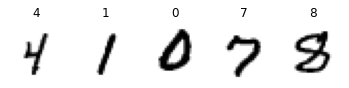

In [124]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [125]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"])) # 명시적 변환
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [126]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [127]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True) # label 존재하는 데이터 셋에 대해 자동으로 구분 지어줌
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 31.9237 - accuracy: 0.8433
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 25.8459 - accuracy: 0.8685
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 24.8779 - accuracy: 0.8729
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 24.7098 - accuracy: 0.8751
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 24.0455 - accuracy: 0.8778


# TensorFlow Hub
- https://www.tensorflow.org/hub?hl=ko
- 머신러닝 모듈(모델) 라이브러리

In [128]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [129]:
import tensorflow_hub as hub
# tf2-preview/nnlm-en-dim50 : Token based text embedding trained on English Google News 7B corpus.
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
# 기 학습된 model 을 layer로 연결하여 transfer learning 등을 손쉽게 할 수 잇음
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [130]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
  return dot(a, b)/(norm(a)*norm(b))

In [131]:
# 기 학습된 word embedding 모델을 통한 (50,1) 의 embedded vector 생성
sentences = tf.constant([
                         "It was a great movie", 
                         "The actors were amazing", 
                         "If you're a fan of epic adventure movies then this is your dream come true", 
                         "Bad acting bad scenes bad movie",
                         "I wanted to give it a shot despite the bad ratings"
                      
                         ])
embeddings = hub_layer(sentences)
cos_sim(embeddings[0], embeddings[1])

0.4091607

In [132]:
cos_sim(embeddings[1], embeddings[2])

0.33881444

In [133]:
cos_sim(embeddings[2], embeddings[4])

0.45622683

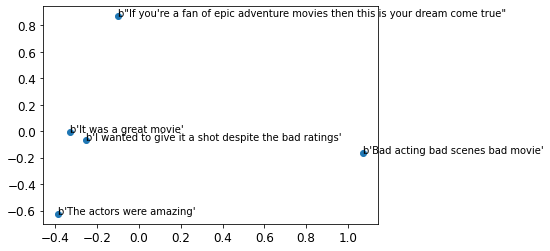

In [134]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
result = pca.fit_transform(embeddings)

fig, ax = plt.subplots()
ax.scatter(result[:, 0], result[:, 1])

for i, txt in enumerate(sentences):
    ax.annotate(sentences[i].numpy(), (result[i, 0], result[i, 1]))

In [135]:
embeddings

<tf.Tensor: shape=(5, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       